### 1 - Import test data

In [59]:
import pandas as pd
import pandas_ta as ta

df = pd.read_csv("EURUSD_Candlestick_5_M_ASK_30.09.2019-30.09.2022.csv")
df["Gmt time"]=df["Gmt time"].str.replace(".000","")
df['Gmt time']=pd.to_datetime(df['Gmt time'],format='%d.%m.%Y %H:%M:%S')
df=df[df.High!=df.Low]
df.set_index("Gmt time", inplace=True)

In [60]:
df["EMA_slow"]=ta.ema(df.Close, length=50)
df["EMA_fast"]=ta.ema(df.Close, length=30)
df['RSI']=ta.rsi(df.Close, length=10)
my_bbands = ta.bbands(df.Close, length=15, std=1.5)
df['ATR']=ta.atr(df.High, df.Low, df.Close, length=7)
df=df.join(my_bbands)
df

,Open,High,Low,Close,Volume,EMA_slow,EMA_fast,RSI,ATR,BBL_15_1.5,BBM_15_1.5,BBU_15_1.5,BBB_15_1.5,BBP_15_1.5
Gmt time,,,,,,,,,,,,,,
2019-09-30 00:00:00,1.09425,1.09426,1.09405,1.09406,585.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-30 00:05:00,1.09408,1.09414,1.09401,1.09409,289.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-30 00:10:00,1.09410,1.09423,1.09408,1.09410,276.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-30 00:15:00,1.09409,1.09410,1.09388,1.09389,439.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-30 00:20:00,1.09390,1.09395,1.09388,1.09395,341.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-30 20:35:00,0.98028,0.98034,0.98001,0.98022,624.12,0.979837,0.980175,47.042955,0.000423,0.979757,0.980317,0.980877,0.114260,0.413104
2022-09-30 20:40:00,0.98023,0.98047,0.98007,0.98030,408.20,0.979855,0.980183,49.010705,0.000420,0.979809,0.980344,0.980879,0.109099,0.458861
2022-09-30 20:45:00,0.98026,0.98034,0.98019,0.98031,317.29,0.979873,0.980191,49.272498,0.000381,0.979943,0.980391,0.980838,0.091333,0.409912


In [61]:
# def ema_signal(df, current_candle, backcandles):
#     df_slice = df.reset_index().copy()
#     # Get the range of candles to consider
#     start = max(0, current_candle - backcandles)
#     end = current_candle
#     relevant_rows = df_slice.iloc[start:end]

#     # Check if all EMA_fast values are below EMA_slow values
#     if all(relevant_rows["EMA_fast"] < relevant_rows["EMA_slow"]):
#         return 1
#     elif all(relevant_rows["EMA_fast"] > relevant_rows["EMA_slow"]):
#         return 2
#     else:
#         return 0


# df = df[-40000:-1]
# df.reset_index(inplace=True, drop=True)
# from tqdm import tqdm
# tqdm.pandas()
# df['EMASignal'] = df.progress_apply(lambda row: ema_signal(df, row.name, 7) if row.name >= 20 else 0, axis=1)


#--------------------------------------------------------------------------------------------------------------------
def ema_signal(df, backcandles):
    # Create boolean Series for conditions
    above = df['EMA_fast'] > df['EMA_slow']
    below = df['EMA_fast'] < df['EMA_slow']

    # Rolling window to check if condition is met consistently over the window
    above_all = above.rolling(window=backcandles).apply(lambda x: x.all(), raw=True).fillna(0).astype(bool)
    below_all = below.rolling(window=backcandles).apply(lambda x: x.all(), raw=True).fillna(0).astype(bool)

    # Assign signals based on conditions
    df['EMASignal'] = 0  # Default no signal
    df.loc[above_all, 'EMASignal'] = 2  # Signal 2 where EMA_fast consistently above EMA_slow
    df.loc[below_all, 'EMASignal'] = 1  # Signal 1 where EMA_fast consistently below EMA_slow

    return df

df=df[-100000:]
df.reset_index(inplace=True, drop=True)
df = ema_signal(df,  7)
#--------------------------------------------------------------------------------------------------------------------


C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\1154505123.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [62]:
# def total_signal(df, current_candle, backcandles):
#     if (ema_signal(df, current_candle, backcandles)==2
#         and (df.Open[current_candle]<=df['BBL_15_1.5'][current_candle] or df.Close[current_candle]<=df['BBL_15_1.5'][current_candle])
#         ):
#             return 2
#     if (ema_signal(df, current_candle, backcandles)==1
#         and (df.Open[current_candle]>=df['BBU_15_1.5'][current_candle] or df.Close[current_candle]>=df['BBU_15_1.5'][current_candle])
#         ):
    
#             return 1
#     return 0
        
# df['Total_Signal'] = df.progress_apply(lambda row: total_signal(df, row.name, 7), axis=1)

def total_signal(df):
    # Vectorized conditions for total_signal
    condition_buy = (df['EMASignal'] == 2) & (df['Close'] <= df['BBL_15_1.5'])
    condition_sell = (df['EMASignal'] == 1) & (df['Close'] >= df['BBU_15_1.5'])

    # Assigning signals based on conditions
    df['Total_Signal'] = 0  # Default no signal
    df.loc[condition_buy, 'Total_Signal'] = 2
    df.loc[condition_sell, 'Total_Signal'] = 1

total_signal(df)


C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\4030472288.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [63]:
import numpy as np
def calculate_rsi_signal_windowed(rsi_series):
    rsi_signal = np.zeros(len(rsi_series))
    for i in range(len(rsi_series)):
        window_start = max(0, i - 5)  # Adjusting to the correct window size
        window = rsi_series[window_start:i]  # Excludes the current value, as intended
        # Apply conditions within the window
        if not window.empty and window.gt(50.1).all():
            rsi_signal[i] = 2
        elif not window.empty and window.lt(49.9).all():
            rsi_signal[i] = 1
        # Else, it remains 0
    return rsi_signal

# Apply the function to calculate RSI_signal
df['RSI_signal'] = calculate_rsi_signal_windowed(df['RSI'])
df['TotalSignal'] = df.apply(lambda row: row['Total_Signal'] if row['Total_Signal'] == row['RSI_signal'] else 0, axis=1)
#df['TotalSignal'] = df["Total_Signal"]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\1076427950.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\1076427950.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [64]:
df.TotalSignal.value_counts()

TotalSignal
0.0    99276
1.0      387
2.0      337
Name: count, dtype: int64

In [65]:
import numpy as np
def pointpos(x):
    if x['TotalSignal']==2:
        return x['Low']-1e-3
    elif x['TotalSignal']==1:
        return x['High']+1e-3
    else:
        return np.nan

df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\2345118794.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



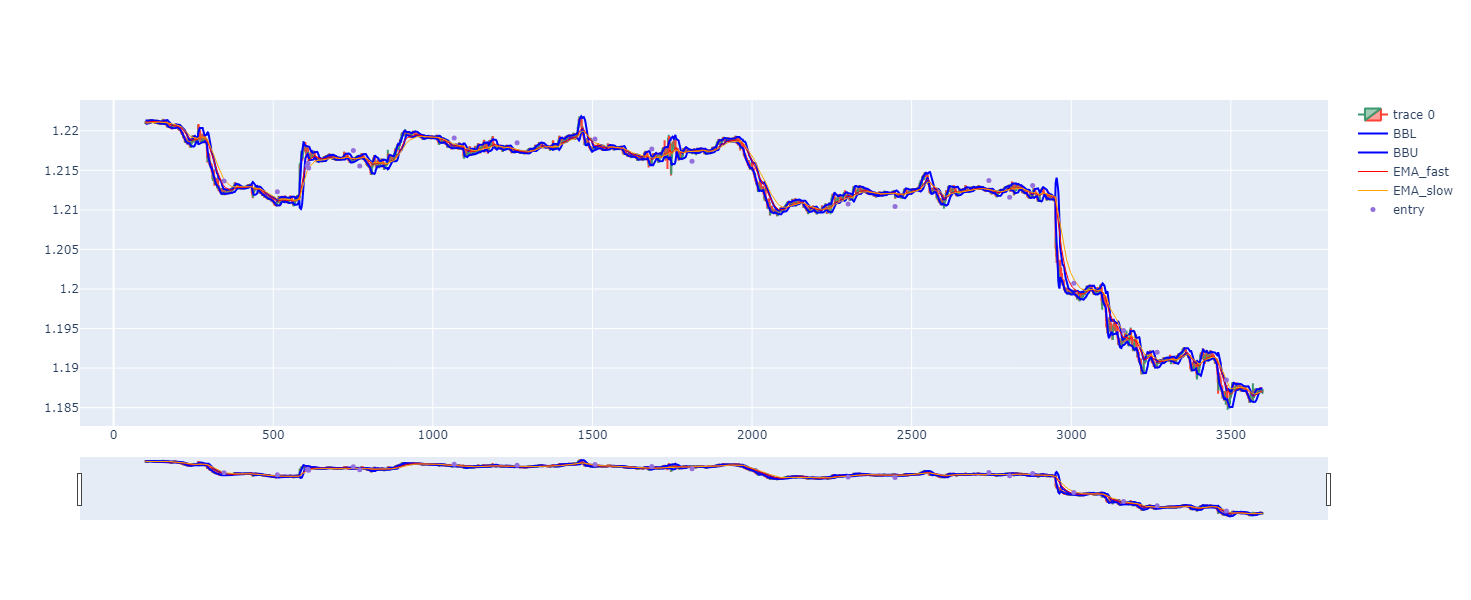

In [66]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
st=100
dfpl = df[st:st+3500]
#dfpl.reset_index(inplace=True)
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close']),

                go.Scatter(x=dfpl.index, y=dfpl['BBL_15_1.5'], 
                           line=dict(color='blue', width=2), 
                           name="BBL"),
                go.Scatter(x=dfpl.index, y=dfpl['BBU_15_1.5'], 
                           line=dict(color='blue', width=2), 
                           name="BBU"),
                go.Scatter(x=dfpl.index, y=dfpl['EMA_fast'], 
                           line=dict(color='red', width=1), 
                           name="EMA_fast"),
                go.Scatter(x=dfpl.index, y=dfpl['EMA_slow'], 
                           line=dict(color='orange', width=1), 
                           name="EMA_slow")])

fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="entry")
fig.update_layout(height=600)
fig.show()

In [53]:
from backtesting import Strategy
from backtesting import Backtest

dfopt = df[-10000:-5000]
def SIGNAL():
    return dfopt.TotalSignal

class MyStrat(Strategy):
    mysize = 0.5
    slcoef = 1.1
    TPSLRatio = 1.5
    
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]
        TPSLRatio = self.TPSLRatio
       
        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr*TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize)
        
        elif self.signal1==1 and len(self.trades)==0:         
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

bt = Backtest(dfopt, MyStrat, cash=1000, margin=1/30)
stats, heatmap = bt.optimize(slcoef=[i/10 for i in range(10, 26)],
                    TPSLRatio=[i/10 for i in range(10, 26)],
                    maximize='Return [%]', max_tries=300,
                        random_state=0,
                        return_heatmap=True)
stats

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\2258769914.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



  0%|          | 0/8 [00:00<?, ?it/s]

Start                                 50000.0
End                                   54999.0
Duration                               4999.0
Exposure Time [%]                        15.0
Equity Final [$]                  1072.799786
Equity Peak [$]                   1090.300399
Return [%]                           7.279979
Buy & Hold Return [%]               -3.552225
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                    -9.67327
Avg. Drawdown [%]                   -2.056172
Max. Drawdown Duration                 2645.0
Avg. Drawdown Duration                 359.75
# Trades                                 26.0
Win Rate [%]                        30.769231
Best Trade [%]                       0.382273
Worst Trade [%]                     -0.153007
Avg. Trade [%]                    

In [10]:
stats["_strategy"]

<Strategy MyStrat(slcoef=2.0,TPSLRatio=2.5)>

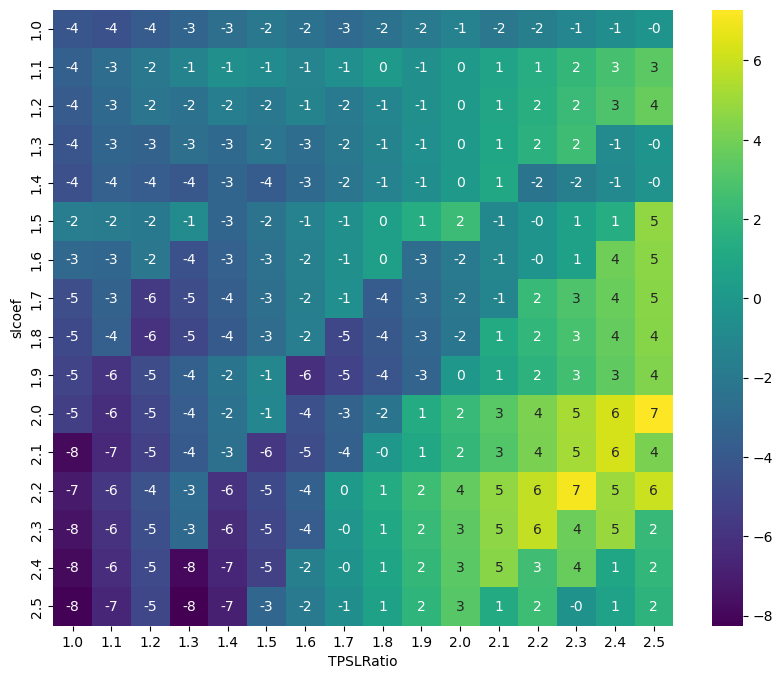

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
plt.show()

In [54]:
from backtesting import Strategy
from backtesting import Backtest

dftest = df[-5000:]
def SIGNAL():
    return dftest.TotalSignal

class MyStrat(Strategy):
    mysize = 0.5
    slcoef = 2.0
    TPSLRatio = 2.5
    
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]
        TPSLRatio = self.TPSLRatio
       
        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr*TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize)
        
        elif self.signal1==1 and len(self.trades)==0:         
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

bt = Backtest(dftest, MyStrat, cash=1000, margin=1/30)
bt.run()

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3481562319.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Start                                 55000.0
End                                   59999.0
Duration                               4999.0
Exposure Time [%]                       22.48
Equity Final [$]                  1042.659774
Equity Peak [$]                   1211.060711
Return [%]                           4.265977
Buy & Hold Return [%]                -0.83158
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                    -18.3789
Avg. Drawdown [%]                   -1.238721
Max. Drawdown Duration                 3333.0
Avg. Drawdown Duration                  126.5
# Trades                                 32.0
Win Rate [%]                           34.375
Best Trade [%]                       0.699683
Worst Trade [%]                     -0.240083
Avg. Trade [%]                    

In [13]:
bt.plot()

GridPlot(id='p1307', ...)

In [55]:
class MyStrat(Strategy):
    mysize = 0.5
    slcoef = 2.0
    TPSLRatio = 2.5
    
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]
        TPSLRatio = self.TPSLRatio

        if len(self.trades)==1:
            self.trades[-1].sl = self.trades[-1].entry_price
       
        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr*TPSLRatio
            tp2 = self.data.Close[-1] + slatr*TPSLRatio/2
            #tp2 = tp1 - slatr*TPSLRatio/2
            self.buy(sl=sl1, tp=tp1, size=self.mysize/2)
            self.buy(sl=sl1, tp=tp2, size=self.mysize/2)
        
        elif self.signal1==1 and len(self.trades)==0:         
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            tp2 = tp1 = self.data.Close[-1] - slatr*TPSLRatio/2
            #tp2 = tp1 + slatr*TPSLRatio/2
            self.sell(sl=sl1, tp=tp1, size=self.mysize/2)
            self.sell(sl=sl1, tp=tp2, size=self.mysize/2)

bt = Backtest(dftest, MyStrat, cash=1000, margin=1/30)
bt.run()

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\1388449531.py:34: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Start                                 55000.0
End                                   59999.0
Duration                               4999.0
Exposure Time [%]                       15.58
Equity Final [$]                  1217.145691
Equity Peak [$]                   1217.145691
Return [%]                          21.714569
Buy & Hold Return [%]                -0.83158
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -9.392941
Avg. Drawdown [%]                   -1.017732
Max. Drawdown Duration                 2035.0
Avg. Drawdown Duration             120.176471
# Trades                                 70.0
Win Rate [%]                             50.0
Best Trade [%]                         0.4359
Worst Trade [%]                     -0.159567
Avg. Trade [%]                    

In [15]:
bt.plot()

GridPlot(id='p1637', ...)

# Loop Forward Testing

In [67]:
from backtesting import Strategy
from backtesting import Backtest

def fit_parameters(df_test):
    def SIGNAL():
        return df_test.TotalSignal
    
    class MyStrat(Strategy):
        mysize = 0.5
        slcoef = 1.1
        TPSLRatio = 1.5
        
        def init(self):
            super().init()
            self.signal1 = self.I(SIGNAL)

        def next(self):
            super().next()
            slatr = self.slcoef*self.data.ATR[-1]
            TPSLRatio = self.TPSLRatio

            if len(self.trades)==1:
                self.trades[-1].sl = self.trades[-1].entry_price
       
            if self.signal1==2 and len(self.trades)==0:
                sl1 = self.data.Close[-1] - slatr
                tp1 = self.data.Close[-1] + slatr*TPSLRatio
                tp2 = self.data.Close[-1] + slatr*TPSLRatio/2
                #tp2 = tp1 - slatr*TPSLRatio/2
                self.buy(sl=sl1, tp=tp1, size=self.mysize/2)
                self.buy(sl=sl1, tp=tp2, size=self.mysize/2)
        
            elif self.signal1==1 and len(self.trades)==0:         
                sl1 = self.data.Close[-1] + slatr
                tp1 = self.data.Close[-1] - slatr*TPSLRatio
                tp2 = tp1 = self.data.Close[-1] - slatr*TPSLRatio/2
                #tp2 = tp1 + slatr*TPSLRatio/2
                self.sell(sl=sl1, tp=tp1, size=self.mysize/2)
                self.sell(sl=sl1, tp=tp2, size=self.mysize/2)
    
    bt = Backtest(df_test, MyStrat, cash=1000, margin=1/30)
    stats, heatmap = bt.optimize(slcoef=[i/10 for i in range(10, 26)],
                        TPSLRatio=[i/10 for i in range(10, 26)],
                        maximize='Return [%]', max_tries=300,
                            random_state=0,
                            return_heatmap=True)

    return (stats["_strategy"].slcoef, stats["_strategy"].TPSLRatio)

In [68]:
def test_parameters(df, slcoef_in, TPSLRatio_in):
    def SIGNAL():
        return df.TotalSignal

    class MyStrat(Strategy):
        mysize = 0.5
        slcoef = slcoef_in
        TPSLRatio = TPSLRatio_in
        
        def init(self):
            super().init()
            self.signal1 = self.I(SIGNAL)

        def next(self):
            super().next()
            slatr = self.slcoef*self.data.ATR[-1]
            TPSLRatio = self.TPSLRatio

            if len(self.trades)==1:
                self.trades[-1].sl = self.trades[-1].entry_price
       
            if self.signal1==2 and len(self.trades)==0:
                sl1 = self.data.Close[-1] - slatr
                tp1 = self.data.Close[-1] + slatr*TPSLRatio
                tp2 = self.data.Close[-1] + slatr*TPSLRatio/2
                #tp2 = tp1 - slatr*TPSLRatio/2
                self.buy(sl=sl1, tp=tp1, size=self.mysize/2)
                self.buy(sl=sl1, tp=tp2, size=self.mysize/2)
        
            elif self.signal1==1 and len(self.trades)==0:         
                sl1 = self.data.Close[-1] + slatr
                tp1 = self.data.Close[-1] - slatr*TPSLRatio
                tp2 = tp1 = self.data.Close[-1] - slatr*TPSLRatio/2
                #tp2 = tp1 + slatr*TPSLRatio/2
                self.sell(sl=sl1, tp=tp1, size=self.mysize/2)
                self.sell(sl=sl1, tp=tp2, size=self.mysize/2)

    bt = Backtest(df, MyStrat, cash=1000, margin=1/30)
    test_stats = bt.run()
    return test_stats["Return [%]"]

In [70]:
tperiod=int(5000)
half_period = int(tperiod/2)
res = []
for i in range(-100000,-2*tperiod,tperiod):
    print(">>>> i >>>> :", i)
    df_fit = df[i:i+tperiod]
    df_test = df[i+tperiod:i+2*tperiod]
    a, b = fit_parameters(df_fit)
    ret = test_parameters(df_test, a, b)
    res.append(ret)

>>>> i >>>> : -100000


C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3139026.py:41: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3379961392.py:38: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3139026.py:41: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -95000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3379961392.py:38: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3139026.py:41: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -90000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3379961392.py:38: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3139026.py:41: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -85000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3379961392.py:38: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3139026.py:41: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -80000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3379961392.py:38: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3139026.py:41: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -75000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3379961392.py:38: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3139026.py:41: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -70000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3379961392.py:38: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3139026.py:41: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -65000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3379961392.py:38: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3139026.py:41: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -60000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3379961392.py:38: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3139026.py:41: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -55000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3379961392.py:38: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3139026.py:41: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -50000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3379961392.py:38: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3139026.py:41: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -45000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3379961392.py:38: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3139026.py:41: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -40000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3379961392.py:38: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3139026.py:41: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -35000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3379961392.py:38: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3139026.py:41: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -30000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3379961392.py:38: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3139026.py:41: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -25000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3379961392.py:38: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3139026.py:41: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -20000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3379961392.py:38: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3139026.py:41: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -15000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\3379961392.py:38: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



In [71]:
res

[2.876034109367538,
 -2.555802581080866,
 6.26000089602835,
 -3.9024758260663246,
 -0.7578261046916168,
 0.05084520926056939,
 -1.5426400426366627,
 -0.11477898272318043,
 -0.3983251915684832,
 9.664357692962085,
 -4.1580156378635476,
 -6.22773682407426,
 -18.61208408283496,
 1.7448865368633617,
 0.4957290966185497,
 9.02351649773766,
 -4.626730624568802,
 -2.595352402572928]

In [72]:
sum(res)


-15.376398261843518

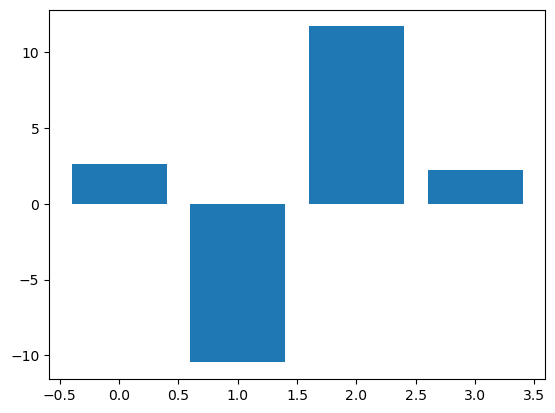

In [34]:
import matplotlib.pyplot as plt

plt.bar(range(len(res)), res)
plt.show()


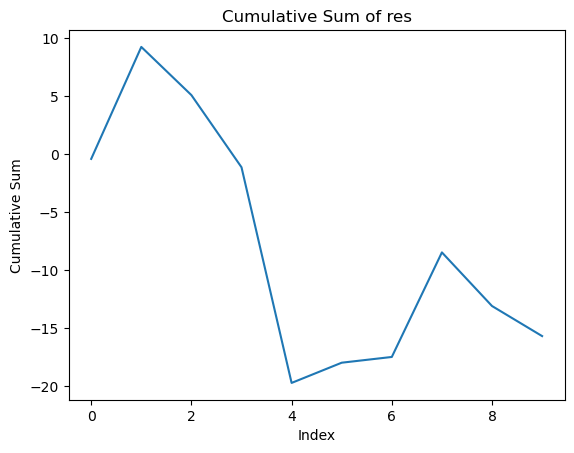

In [41]:
import matplotlib.pyplot as plt
import numpy as np
res = np.array(res) # Assuming res is already defined
plt.plot(np.cumsum(res))
plt.title("Cumulative Sum of res")
plt.xlabel("Index")
plt.ylabel("Cumulative Sum")
plt.show()


In [73]:
from backtesting import Strategy
from backtesting import Backtest

def fit_parameters(df_test):
    def SIGNAL():
        return df_test.TotalSignal
    
    class MyStrat(Strategy):
        mysize = 0.5
        slcoef = 1.1
        TPSLRatio = 1.5
        
        def init(self):
            super().init()
            self.signal1 = self.I(SIGNAL)

        def next(self):
            super().next()
            slatr = self.slcoef*self.data.ATR[-1]
            TPSLRatio = self.TPSLRatio
       
            if self.signal1==2 and len(self.trades)==0:
                sl1 = self.data.Close[-1] - slatr
                tp1 = self.data.Close[-1] + slatr*TPSLRatio
                self.buy(sl=sl1, tp=tp1, size=self.mysize)
        
            elif self.signal1==1 and len(self.trades)==0:         
                sl1 = self.data.Close[-1] + slatr
                tp1 = self.data.Close[-1] - slatr*TPSLRatio
                self.sell(sl=sl1, tp=tp1, size=self.mysize)
    
    bt = Backtest(df_test, MyStrat, cash=1000, margin=1/30)
    stats, heatmap = bt.optimize(slcoef=[i/10 for i in range(10, 26)],
                        TPSLRatio=[i/10 for i in range(10, 26)],
                        maximize='Return [%]', max_tries=300,
                            random_state=0,
                            return_heatmap=True)

    return (stats["_strategy"].slcoef, stats["_strategy"].TPSLRatio)

In [74]:
def test_parameters(df, slcoef_in, TPSLRatio_in):
    def SIGNAL():
        return df.TotalSignal

    class MyStrat(Strategy):
        mysize = 0.5
        slcoef = slcoef_in
        TPSLRatio = TPSLRatio_in
        
        def init(self):
            super().init()
            self.signal1 = self.I(SIGNAL)

        def next(self):
            super().next()
            slatr = self.slcoef*self.data.ATR[-1]
            TPSLRatio = self.TPSLRatio
       
            if self.signal1==2 and len(self.trades)==0:
                sl1 = self.data.Close[-1] - slatr
                tp1 = self.data.Close[-1] + slatr*TPSLRatio
                self.buy(sl=sl1, tp=tp1, size=self.mysize)
        
            elif self.signal1==1 and len(self.trades)==0:         
                sl1 = self.data.Close[-1] + slatr
                tp1 = self.data.Close[-1] - slatr*TPSLRatio
                self.sell(sl=sl1, tp=tp1, size=self.mysize)

    bt = Backtest(df, MyStrat, cash=1000, margin=1/30)
    test_stats = bt.run()
    return test_stats["Return [%]"]

In [75]:
tperiod=int(5000)
half_period = int(tperiod/2)
res = []
for i in range(-100000,-2*tperiod,tperiod):
    print(">>>> i >>>> :", i)
    df_fit = df[i:i+tperiod]
    df_test = df[i+tperiod:i+2*tperiod]
    a, b = fit_parameters(df_fit)
    ret = test_parameters(df_test, a, b)
    res.append(ret)

>>>> i >>>> : -100000


C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\1726184871.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\2242779686.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\1726184871.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -95000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\2242779686.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\1726184871.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -90000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\2242779686.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\1726184871.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -85000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\2242779686.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\1726184871.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -80000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\2242779686.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\1726184871.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -75000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\2242779686.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\1726184871.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -70000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\2242779686.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\1726184871.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -65000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\2242779686.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\1726184871.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -60000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\2242779686.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\1726184871.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -55000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\2242779686.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\1726184871.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -50000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\2242779686.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\1726184871.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -45000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\2242779686.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\1726184871.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -40000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\2242779686.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\1726184871.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -35000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\2242779686.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\1726184871.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -30000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\2242779686.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\1726184871.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -25000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\2242779686.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\1726184871.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -20000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\2242779686.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\1726184871.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



>>>> i >>>> : -15000


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Bartek\AppData\Local\Temp\ipykernel_17900\2242779686.py:29: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



In [76]:
res

[-4.381384491900917,
 -3.841430334614711,
 10.571026232270082,
 -0.6418066392289689,
 -3.7812498896759736,
 1.7135337517302218,
 -10.527055753391187,
 -1.559226476687138,
 -0.23465463122519167,
 10.630111006205583,
 -1.974574034242687,
 22.658938611742133,
 -26.012516623845215,
 -0.2803092519487564,
 16.855557597936013,
 7.884201776485998,
 -25.69070756201539,
 -2.926046762169085]

In [78]:
sum(res)

-11.537593474575187